# 🤔 Decision Analysis - Project 3: Preference learning
* Zuzanna Gawrysiak: 148255
* Agata Żywot: 148258

Data source: https://en.cs.uni-paderborn.de/is/research/research-projects/software/monotone-learning-datasets (mammographic)

## Import necessary libraries

In [46]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
import xgboost as xgb
from xgboost import plot_tree
import pandas as pd
import matplotlib.pyplot as plt
import shap
import dalex as dx
import torch
from tqdm.notebook import tqdm as tqdm

from src.neural_net import SimpleNN, Train_NN
from src.xgboost import create_xgb_model
from src.interpret import add_measures, score_model, shap_tree_explainer, plot_marginal_values_ann_utadis, plot_measures
from src.helpers import CreateDataLoader, Train
from src.nb_UTA import *

## Data
Note - the `mammographic` dataset used is not described in terms of the meaning of a particular criterio, hence we will use `Criterion #1`, `Criterion #2` etc.

In [2]:
DATA_PATH = "data/mammographic.csv"
data = pd.read_csv(DATA_PATH, header=None)
records = len(data)
data = data.drop_duplicates()
print(f'Number of duplicate records: {records-len(data)}')

Number of duplicate records: 266


In [3]:
columns_dict = {0: 'Criterion #1', 1: 'Criterion #2', 2: 'Criterion #3', 3: 'Criterion #4', 4: 'Criterion #5', 5:'Target'}
data.rename(columns=columns_dict, inplace=True)
data.describe()

,Criterion #1,Criterion #2,Criterion #3,Criterion #4,Criterion #5,Target
count,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,0.079884,0.485088,0.615248,0.471631,0.626478,0.496454
std,0.041198,0.193954,0.397242,0.381164,0.138930,0.500431
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.072727,0.346154,0.333333,0.000000,0.666667,0.000000
50%,0.072727,0.500000,0.666667,0.500000,0.666667,0.000000
75%,0.090909,0.628205,1.000000,0.750000,0.666667,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


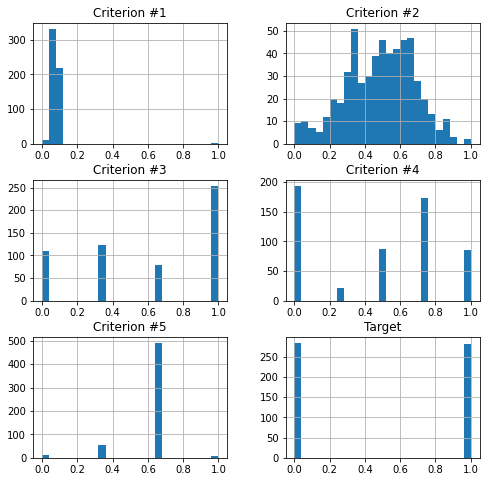

In [4]:
data.hist(bins=25, figsize=(8, 8));

In [5]:
data.quantile([0.99])

,Criterion #1,Criterion #2,Criterion #3,Criterion #4,Criterion #5,Target
0.99,0.109091,0.871795,1.0,1.0,1.0,1.0


There are no missing values, one can instatnly notice the dataset is balanced (criterion 5 treated as target). <br>However, it can be seen that the criterion 0 is highly imbalanced and almost all examples oscilates between 0.0-0.1 (quantiles).

In [6]:
criteria_nr = 5
data_input = data.iloc[:, :criteria_nr]
data_target = data['Target']

display(data_input.head())
display(data_target.head())

,Criterion #1,Criterion #2,Criterion #3,Criterion #4,Criterion #5
0,0.090909,0.628205,0.666667,1.00,0.666667
1,0.090909,0.512821,1.000000,1.00,0.666667
2,0.072727,0.128205,0.000000,0.00,0.666667
3,0.090909,0.500000,0.000000,1.00,0.666667
4,0.090909,0.743590,0.000000,0.75,0.666667


0    1.0
1    1.0
2    0.0
3    1.0
4    1.0
Name: Target, dtype: float64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target, test_size=0.2, random_state=1234
)

## Experiments

In [8]:
MEASURES = dict() # used to store measures for each model

### ML model - XGBoost

In [9]:
model_xgboost = create_xgb_model(criteria_nr)
model_xgboost.fit(X_train, y_train);

In [10]:
y_pred = model_xgboost.predict(X_train)

accuracy, f1, auc = score_model(y_train, y_pred)
print(f"Train\nAccuracy: {accuracy}\nF1: {f1}\nAUC: {auc}")
MEASURES = add_measures(MEASURES, (accuracy, f1, auc), 'XGBoost', 'train')

Train
Accuracy: 0.7982
F1: 0.7859
AUC: 0.7974


In [11]:
y_pred = model_xgboost.predict(X_test)

accuracy, f1, auc = score_model(y_test, y_pred)
print(f"Test\nAccuracy: {accuracy}\nF1: {f1}\nAUC: {auc}")
MEASURES = add_measures(MEASURES, (accuracy, f1, auc), 'XGBoost', 'test')

Test
Accuracy: 0.8319
F1: 0.8224
AUC: 0.8358


#### Interpreting the model

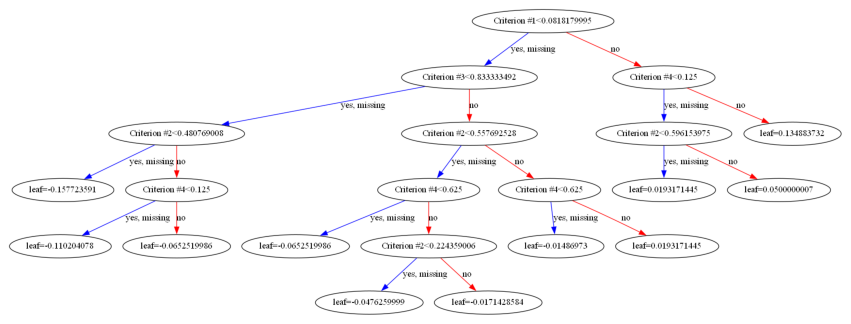

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_tree(model_xgboost, ax=ax, num_trees=0);

Note: `Criterion #5` has not been used at any level (meaning no contribution of this feature).

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


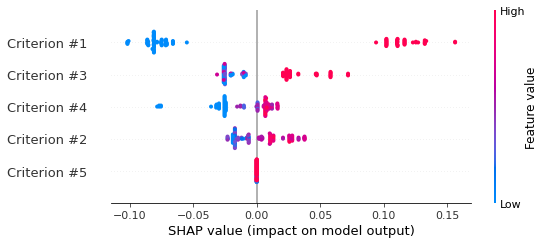

In [13]:
shap_explainer, shap_values = shap_tree_explainer(model_xgboost, X_test, y_pred)

The plot shows the `Criterion #1` (the imbalanced one) has the greatest impact on the final decision, `Criterion #5`'s impact is, on the other hand, negligible.    

In [14]:
dalex_explainer = dx.Explainer(model_xgboost, X_train, y_train, label="XGBoost")

Preparation of a new explainer is initiated

  -> data              : 451 rows 5 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 451 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGBoost
  -> predict function  : <function yhat_proba_default at 0x000001D8869468C0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.461, mean = 0.498, max = 0.534
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.534, mean = -0.00791, max = 0.539
  -> model_info        : package xgboost

A new explainer has been created!


In [15]:
fi = dalex_explainer.model_parts()
fi.plot()

Feature importance is also consistent with Dalex approach (how much the model would worsen if a particular feature was removed - more precisely shuffled here).

#### Taking 3 alternatives and veryfing what the minimum change to a single criterion should be done to change classification

In [16]:
SAMPLES_3 = X_test.iloc[:3].copy()
SAMPLES_3

,Criterion #1,Criterion #2,Criterion #3,Criterion #4,Criterion #5
682,0.072727,0.628205,0.0,0.75,0.666667
266,0.072727,0.346154,0.0,0.25,0.666667
231,0.072727,0.628205,1.0,0.00,0.666667


In [17]:
y_pred = model_xgboost.predict(SAMPLES_3)
y_pred

array([0, 0, 0])

In [18]:
dalex_explainer.predict_profile(SAMPLES_3).plot()

Calculating ceteris paribus: 100%|██████████| 5/5 [00:00<00:00, 60.99it/s]


For all the alternatives the minimal value to change classifications seems to exist for `Criterion #1`. Note that for `Criterion #2` and `Criterion #5` (no surprise in this case) there are no change that would change the prediction

In [19]:
# changing the values to verify theoretical predictions
samples_3 = SAMPLES_3.copy()
samples_3['Criterion #1'] = 0.09
samples_3

,Criterion #1,Criterion #2,Criterion #3,Criterion #4,Criterion #5
682,0.09,0.628205,0.0,0.75,0.666667
266,0.09,0.346154,0.0,0.25,0.666667
231,0.09,0.628205,1.0,0.00,0.666667


In [20]:
y_pred = model_xgboost.predict(samples_3)
y_pred

array([1, 1, 1])

The results agree with theoretical predictions.

In [21]:
# explaining predictions for each object
shap.initjs()
shap.force_plot(shap_explainer.expected_value, shap_values[0,:], samples_3.iloc[0], link="logit")

In [22]:
shap.initjs()
shap.force_plot(shap_explainer.expected_value, shap_values[0,:], samples_3.iloc[1], link="logit")

In [23]:
shap.initjs()
shap.force_plot(shap_explainer.expected_value, shap_values[0,:], samples_3.iloc[2], link="logit")

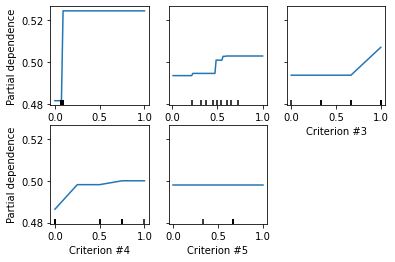

In [24]:
PartialDependenceDisplay.from_estimator(model_xgboost, X_train, [0, 1, 2, 3, 4])

Note: the high slope that can be observable in the case of `Criterion #1` might be associated with the gap regarding the values in this criterion (0-0.1 -> no values in between -> 1).

In [25]:
result = permutation_importance(model_xgboost, X_train, y_train, n_repeats=10, random_state=0)
result.importances_mean

array([0.25210643, 0.02682927, 0.01108647, 0.01441242, 0.        ])

One may notice that the most important feature for the model is `Criterion #1`, which has a feature importance score of approx. 0.2521.<br>The remaining features have much lower importance scores ranging from 0.0 to ~0.02683.

### Neural MCDA - ANN-UTADIS

In [26]:
data_input_nn = data_input.values.reshape(-1, 1, criteria_nr)

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    data_input_nn, data_target.values, test_size=0.2, random_state=1234
)

In [27]:
train_dataloader = CreateDataLoader(X_train_nn, y_train_nn)
test_dataloader = CreateDataLoader(X_test_nn, y_test_nn)

In [28]:
torch.manual_seed(1234) #set seed for reproducibility

ANN_UTA_PATH = "models/uta.pt2"
uta = Uta(criteria_nr, 30)
model_ann_uta = NormLayer(uta, criteria_nr)

acc, acc_test, auc, auc_test, f1, f1_test = Train(model_ann_uta, train_dataloader, test_dataloader, ANN_UTA_PATH)
print("TRAIN:")
print("Accuracy train:\t%.2f%%" % (acc * 100.0))
print("AUC train: \t%.2f%%" % (auc * 100.0))
print("F1 train: \t%.2f%%" % (f1 * 100.0))
print("TEST:")
print("Accuracy test:\t%.2f%%" % (acc_test * 100.0))
print("AUC test: \t%.2f%%" % (auc_test * 100.0))
print("F1 test: \t%.2f%%" % (f1_test * 100.0))

100%|██████████| 200/200 [00:03<00:00, 63.25it/s]

TRAIN:
Accuracy train:	74.94%
AUC train: 	78.57%
F1 train: 	72.77%
TEST:
Accuracy test:	59.29%
AUC test: 	84.82%
F1 test: 	69.74%


In [29]:
MEASURES = add_measures(MEASURES, (acc, f1, auc), 'ANN-UTA', 'train')
MEASURES = add_measures(MEASURES, (acc_test, f1_test, auc_test), 'ANN-UTA', 'test')

In [30]:
# load a model from the path
# checkpoint = torch.load(ANN_UTA_PATH)
# model_ann_uta.load_state_dict(checkpoint["model_state_dict"])

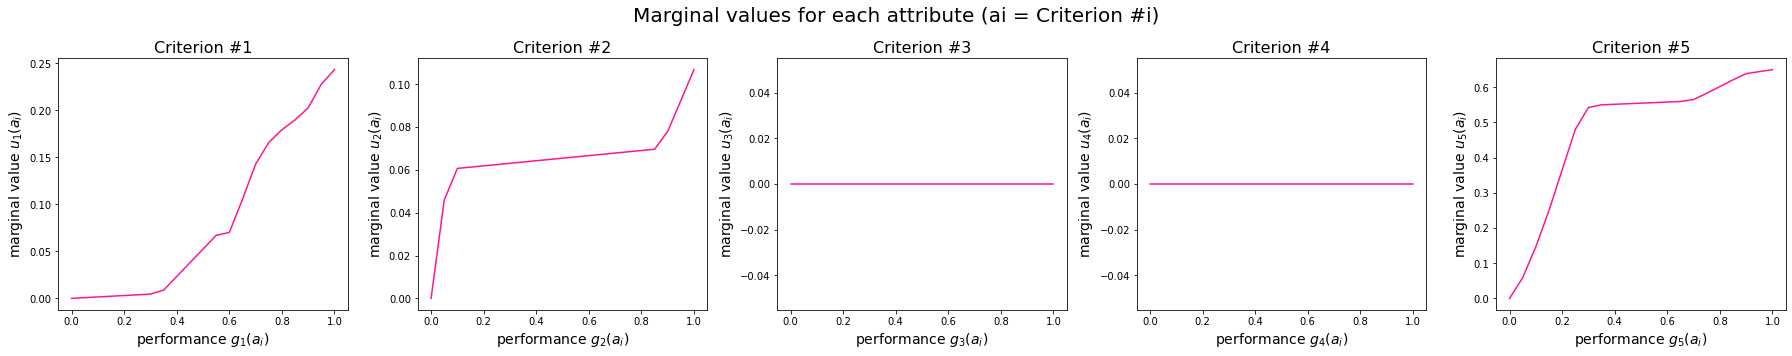

In [31]:
plot_marginal_values_ann_utadis(model_ann_uta, criteria_nr)

One can immediately notice that in this case `Criterion #5` has the greatest marginal value (which is the opposite compared to the XGBoost where this criterion had no influence) and both `Criterion #3` and `Criterion #4` have no impact on the classification.

#### Taking 3 alternatives and veryfing what the minimum change to a single criterion should be done to change classification

In [32]:
indices = [18, 37, 105] # select some samples classified as 0
SAMPLES_3 = X_test_nn[indices].copy()
SAMPLES_3

array([[[0.072727, 0.717949, 0.      , 0.      , 0.      ]],

       [[0.072727, 0.358974, 0.      , 0.      , 0.      ]],

       [[0.072727, 0.051282, 0.333333, 0.      , 0.666667]]])

In [33]:
model_ann_uta.eval()
out = torch.sigmoid(model_ann_uta(torch.from_numpy(SAMPLES_3))).round().detach().numpy()
np.squeeze(out)

array([0., 0., 0.])

In [34]:
# change the value of the most significant criterion
samples_3 = SAMPLES_3.copy()
samples_3[:, :, 4] = 0.72

In [35]:
res_3 = model_ann_uta(torch.from_numpy(samples_3))
out = torch.sigmoid(res_3).round().detach().numpy()
np.squeeze(out)

array([1., 1., 1.])

The results agree with the assumption of `Criterion #5` being the most important here.

### NN

In [36]:
NN_PATH = "models/simple_nn.pt2"

model_nn = SimpleNN()
acc, acc_test, auc, auc_test, f1, f1_test = Train_NN(model_nn, train_dataloader, test_dataloader, NN_PATH, epoch_nr=200, lr=0.01)
print("TRAIN:")
print("Accuracy train:\t%.2f%%" % (acc * 100.0))
print("AUC train: \t%.2f%%" % (auc * 100.0))
print("F1 train: \t%.2f%%" % (f1 * 100.0))
print("TEST:")
print("Accuracy test:\t%.2f%%" % (acc_test * 100.0))
print("AUC test: \t%.2f%%" % (auc_test * 100.0))
print("F1 test: \t%.2f%%" % (f1_test * 100.0))

  0%|          | 0/200 [00:00<?, ?it/s]

TRAIN:
Accuracy train:	73.28%
AUC train: 	82.47%
F1 train: 	75.34%
TEST:
Accuracy test:	73.29%
AUC test: 	87.59%
F1 test: 	78.74%


In [37]:
MEASURES = add_measures(MEASURES, (acc, f1, auc), 'Simple-NN', 'train')
MEASURES = add_measures(MEASURES, (acc_test, f1_test, auc_test), 'Simple-NN', 'test')

#### Interpreting the model

In [38]:
def f(X):
    X = X.astype(np.float32)
    return model_nn(torch.from_numpy(X)).detach().numpy()

In [39]:
model_nn.eval()
xtest = X_test_nn.copy()
xtest = xtest.astype(np.float32)
xtest = X_test_nn.reshape(113,5)

explainer = shap.KernelExplainer(f, X_test, l1_reg="false")
shap_values = explainer.shap_values(xtest)

shap.force_plot(explainer.expected_value[0], shap_values[0], xtest, link="logit")

Using 113 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/113 [00:00<?, ?it/s]

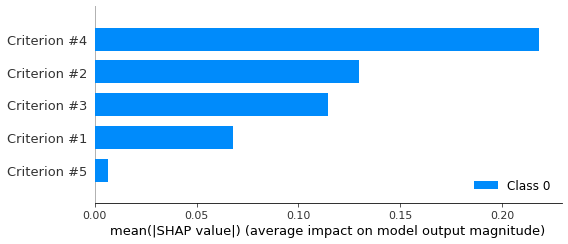

In [40]:
shap.summary_plot(shap_values, X_test)

It can be seen that the `Criterion #4` has the greatest impact on the prediction, following by `Criterion #2` and `Criterion #3`. What is worth noticing, here every feature's importance is of a non-zero value (however `Criterion #5` is pretty much negligible) which was not the case in the previous approaches.

#### Taking 3 alternatives and veryfing what the minimum change to a single criterion should be done to change classification

In [41]:
samples_3

array([[[0.072727, 0.717949, 0.      , 0.      , 0.72    ]],

       [[0.072727, 0.358974, 0.      , 0.      , 0.72    ]],

       [[0.072727, 0.051282, 0.333333, 0.      , 0.72    ]]])

In [42]:
samples_3 = SAMPLES_3.copy()
samples_3 = samples_3.astype(np.float32)
model_nn.eval()
preds = model_nn(torch.from_numpy(samples_3)).round().detach().numpy()
np.squeeze(preds)

array([0., 0., 0.], dtype=float32)

In [43]:
# change the value of the most significant criterion
samples_3[:, :, 3] = 1.9
preds = model_nn(torch.from_numpy(samples_3)).round().detach().numpy()
np.squeeze(preds)

array([1., 1., 1.], dtype=float32)

Changing the value of the most significant criterion (#4) to value 1.9 gives expected results: samples are classified to the different class (`1`).

## Summary

In [44]:
MEASURES

{'XGBoost': {'train': {'accuracy': 0.7982, 'f1': 0.7859, 'auc': 0.7974},
  'test': {'accuracy': 0.8319, 'f1': 0.8224, 'auc': 0.8358}},
 'ANN-UTA': {'train': {'accuracy': 0.7494, 'f1': 0.7277, 'auc': 0.7857},
  'test': {'accuracy': 0.5929, 'f1': 0.6974, 'auc': 0.8482}},
 'Simple-NN': {'train': {'accuracy': 0.7328, 'f1': 0.7534, 'auc': 0.8247},
  'test': {'accuracy': 0.7329, 'f1': 0.7874, 'auc': 0.8759}}}

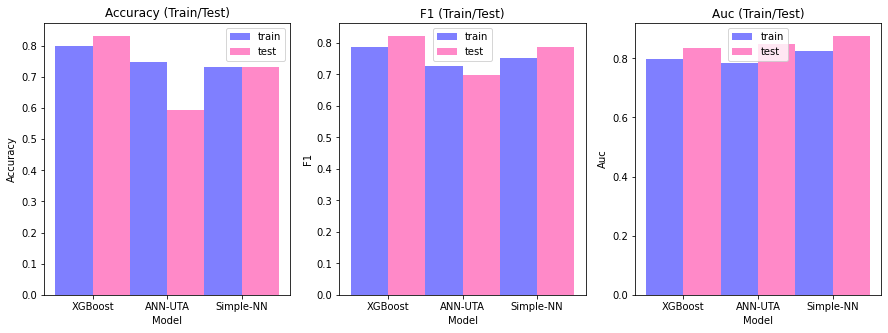

In [45]:
plot_measures(MEASURES)

The plots above summarize the performence of all the aforementioned approaches. 

Starting from the XGBoost, the accuracy and F1 score are higher for the testing dataset than for the training dataset, meaning that the model might not be overfitting to the training data. The AUC for both datasets is relatively high (~80%), with a slightly higher AUC for the testing dataset (the model does not overfit the data).

As for ANN-UTA, the accuracy (especially this one) and F1 score are significantly lower for the testing dataset than for the training dataset, indicating that the model might be overfitting to the training data. However, the AUC for the testing dataset is higher than the AUC for the training dataset and in general outperforms XGBoost on this metric.

In the case of Simple NN, all metrics are better for the testing set which (no overfitting), and the AUC for both datasets is relatively high (train: 82%, test: 88%) <br>
For this particular dataset XGBoost and Simple-NN have more consistent performance across different metrics and datasets, while ANN-UTA has relatively low performance for both accuracy and F1 score in the testing dataset, although it has a higher AUC than Simple-NN for the training dataset. 